# FX Hedge Private Credit Case Study
##### 10th Jan 2026
##### Vasco Ribeiro da Silva
____

The aim of this exercise isn't to construct a fully realistic private credit or FX trading system. It serves to demonstrate how to translate a loosely defined business requirement into quantitative concepts. This includes:

- formulating a concretely defined problem,
- suitability of model choices,
- ability to formulate a solution to the problem.

<br><br>

<u>Economic Framing</u>

We'll be assuming the position of a private credit fund manager, with a USD-denominated fund, whose assets are EUR-denominated. And thus exposed to FX risk. All other risks such as Credit Risk, Interest Rate Risk aren't considered.

 - The investment generate EUR deterministic cashflows as follows:

| Cashflow Date | Cashflow (€ M) |
|---------------|----------------|
| 2025-10-01    | -10            |
| 2026-10-01    | 1              |
| 2027-10-01    | 1              |
| 2029-10-01    | 1              |
| 2030-10-01    | 11             |

 - The fund reports in USD
 - EURUSD FX is the only source of uncertainty affecting the USD value of the investment

<br><br>

<u>Mathematical Framing and Problem Formulation</u>

We define:

 - $\{CF_i^{EUR}\}_{i=1}^N$ as the set of deterministic EUR cashflows,
 - and $\{T_i\}_{i=1}^N$ their corresponding payment dates,
 - $S_t$ denote the EURUSD spot rate (USD per unit of EUR),
 - $t_0$ the analysis (valuation) date.

The unhedged USD cashflows are:

$$CF_i^{USD} = CF_i^{EUR} \cdot S_{T_i}$$

The FX spot rate is the only stochastic driver in the problem. And all other quantitites like cashflows, interest rates, option volatilites are treated deterministically at $t_0$.

The problem is to:
 1. Evaluate the performance of the USD investment and quantify the distribution introduced by FX uncertainty.
 2. Design hedging strategies using financial derivative products that mitigate the risk by modifying the distribution in controlled way.
 3. Identify the risk profiles associated with each hedging strategies and compare them in terms of:
    - downside risk reduction,
    - cost,
    - impact on upside potential.

<u>Table of Contents</u>

 - [0. Importing Libraries](#zero)
 - [1. Loading Data](#one)
    - [1.1. Global Configuration](#one)
    - [1.2. Market Data](#one-two)
    - [1.3. Cashflow Data](#one-three)
 - [2. Simulating FX Paths](#two)
 
<u>Strategies</u>
 
 - [3. Unhedged Strategy](#three)
    - [3.1. Performance Evaluation](#three-one)
    - [3.2. Risk Evaluation](#three-two)
    - [3.3. Results](#three-three)

- [4. Forward Hedge Strategy](#four)
    - [4.1. Performance Evaluation](#four-one)
    - [4.2. Risk Evaluation](#four-two)
    - [4.3. Results](#four-three)

- [5. Option Hedge Strategy](#five)
    - [5.1. Performance Evaluation](#five-one)
    - [5.2. Risk Evaluation](#five-two)
    - [5.3. Results](#five-three)

<u>Results</u>

- [6. Final Results](#six)
    - [6.1. Unhedged Strategy](#six-one)
    - [6.2. Forward Hedge Strategy](#six-two)
    - [6.3. Option Hedge Strategy](#six-three)
    - [6.4. Visualisations](#six-four)

### 0. Importing Libraries<a id='zero'></a>

In [1]:
# Importing Libraries
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.global_variables import GlobalVariables
from src.data_loader import market_data_loader, cashflows_loader, get_spot_prices, get_latest_quote
from src.fx_simulator import estimate_gbm_params, simulate_gbm_paths
from src.metrics.performance import irr, moic, npv, terminal_value
from src.metrics.risk import risk_summary_for_metric, prob_below
from src.hedges.forwards import forward_hedge_cashflows_usd
from src.hedges.options import put_option_hedge_cashflows_usd

### 1. Loading Data <a class='anchor' id='one'></a>
____

##### 1.1. Global Configuration <a class='anchor' id='one-one'></a>

In [2]:
# Set Up
global_variables = GlobalVariables(
    market_data_path='QuantResearch-CaseStudy-MarketData-25.xlsx',
    analysis_start_date=pd.Timestamp('2025-08-01'),
    n_paths=250000
)

colors = {'c1': '#7AA1D2',
          'c2': '#FC354C',
          'c3': '#1D976C',
          'c4': '#0ABFBC'}
          # https://uigradients.com/#MonteCarlo #Miaka

FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(exist_ok=True)

##### 1.2. Market Data <a class='anchor' id='one-two'></a>

In [3]:
# Loading Market Data
market_data = market_data_loader(
    path=global_variables.market_data_path
)
spots = get_spot_prices(
    market_data=market_data,
    price='mid'
)
s0 = get_latest_quote(
    market_data=market_data,
    price='mid',
    analysis_start_date=global_variables.analysis_start_date,
    ticker='spot'
).item()


##### 1.3 Cashflow Data <a class='anchor' id='one-three'></a>

In [4]:
# Loading Cashflow Data
cashflows = cashflows_loader()

### 2, Simulation FX Paths <a class='anchor' id='two'></a>
____

In [5]:
# Calibrating FX Model
mu_hat, sigma_hat = estimate_gbm_params(
    spots=spots,
    steps_per_year=global_variables.steps_per_year,
    use_zero_mu=global_variables.use_zero_mu
)

In [6]:
# Simulate FX Spot Rates
dates, spot_paths = simulate_gbm_paths(
    s0=s0,
    mu=mu_hat,
    sigma=sigma_hat,
    start=global_variables.analysis_start_date,
    end=cashflows.index.max(),
    n_paths= global_variables.n_paths,
    steps_per_year=global_variables.steps_per_year,
)

## 3. Unhedged Strategy <a class='anchor' id='three'></a>
____

##### 3.1 Performance Evaluation <a class='anchor' id='three-one'></a>

In [7]:
# Cashflows and their Dates 
cashflow_dates = np.asarray(cashflows.index)
cashflow_dates_idx = dates.get_indexer(cashflow_dates, method='pad')
cashflow_eur = np.asarray(cashflows['cf_eur'])

# Check Cashflow Dates Within Path Simulation Dates
if (cashflow_dates_idx < 0).any():
    missing = cashflow_dates[cashflow_dates_idx < 0]
    raise ValueError(f'Cashflow dates before simulation begins: {missing}')

# Evaluating Unhedged Performance
hedge_cashflow_usd_unhedged = np.zeros((global_variables.n_paths, cashflows.size))

# Unhedged Performance Metrics
irr_unhedged = np.empty(global_variables.n_paths, dtype=float)
moic_unhedged = np.empty(global_variables.n_paths, dtype=float)
npv_unhedged = np.empty(global_variables.n_paths, dtype=float)
terminal_unhedged = np.empty(global_variables.n_paths, dtype=float)

# Iterating each Simulated Spot Path
for p in range(global_variables.n_paths):
    spots_on_cashflow_dates = spot_paths[p, cashflow_dates_idx]
    cashflow_usd = cashflow_eur * spots_on_cashflow_dates + hedge_cashflow_usd_unhedged[p]

    # Charging Premium
    if global_variables.premium != 0.0:
        cashflow_usd = cashflow_usd.copy()
        cashflow_usd[0] -= global_variables.premium

    irr_unhedged[p] = irr(
        cashflow_dates=cashflow_dates,
        cashflows=cashflow_usd,
        start_date=cashflow_dates[0],
    )
    moic_unhedged[p] = moic(
        cashflows=cashflow_usd
    )
    npv_unhedged[p] = npv(
        cashflow_dates=cashflow_dates,
        cashflows=cashflow_usd,
        r = global_variables.discount_rate,
        start_date=global_variables.analysis_start_date
    )
    terminal_unhedged[p] = terminal_value(
        cashflows=cashflow_usd
    )

performance_unhedged = {
    'strategy': 'unhedged',
    'irr': irr_unhedged,
    'moic': moic_unhedged,
    'npv': npv_unhedged,
    'terminal': terminal_unhedged,
    'premium': global_variables.premium
}

# No Root was found
nan_rate_irr_unhedged = np.isnan(irr_unhedged).mean()
print('IRR NaN rate :', nan_rate_irr_unhedged)

IRR NaN rate : 0.0


##### 3.2 Risk Evaluation <a class='anchor' id='three-two'></a>

In [8]:
# Unhedged Risk
risk_npv_unhedged = risk_summary_for_metric(performance_unhedged['npv'], alpha=global_variables.alpha, loss='npv_shortfall')
risk_irr_unhedged = risk_summary_for_metric(performance_unhedged['irr'], alpha=global_variables.alpha, loss='irr_shortfall')
risk_moic_unhedged = risk_summary_for_metric(performance_unhedged['moic'], alpha=global_variables.alpha, loss='moic_shortfall')

p_npv_neg = prob_below(performance_unhedged['npv'], 0.0)
p_irr_neg = prob_below(performance_unhedged['irr'], 0.0)
p_moic_lt1 = prob_below(performance_unhedged['moic'], 1.0)

##### 3.3 Results <a class='anchor' id='three-three'></a>

/var/folders/vq/vfvbw4712s38pzgg57fngcsm0000gn/T/ipykernel_23905/522240997.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1 = cashflows.index[idx], cumsum[idx]
/var/folders/vq/vfvbw4712s38pzgg57fngcsm0000gn/T/ipykernel_23905/522240997.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2, y2 = cashflows.index[idx+1], cumsum[idx+1]


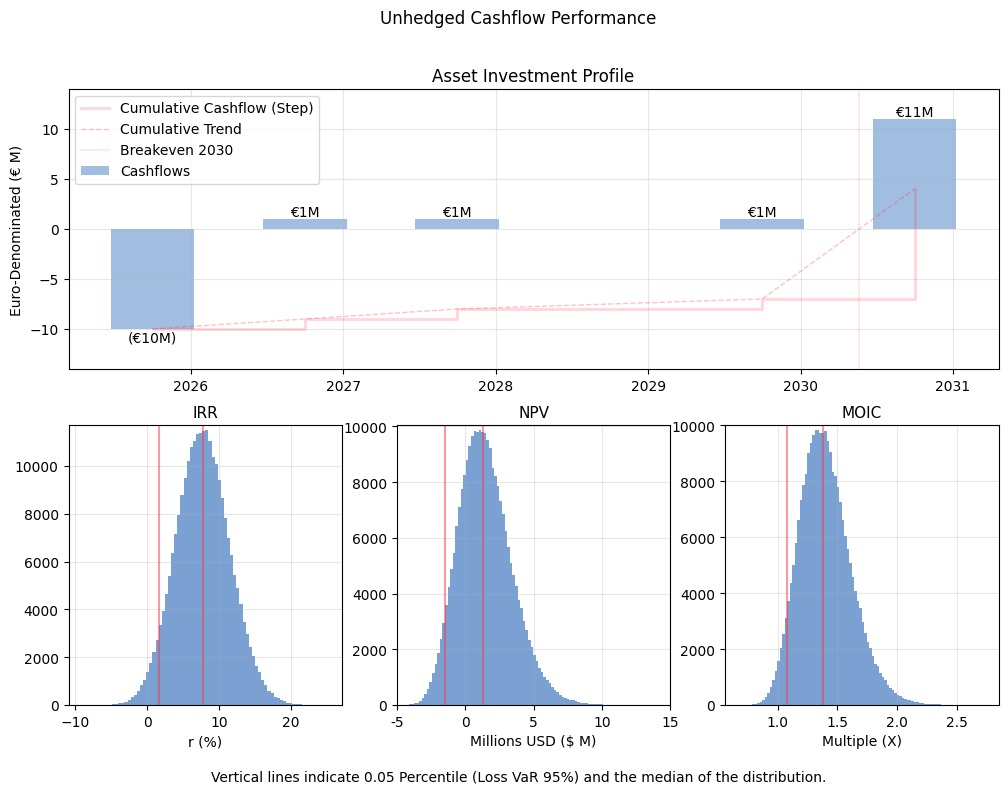

In [9]:
# Unhedged Results
fig = plt.figure(figsize = (12, 8))
plt.suptitle('Unhedged Cashflow Performance')

# Fig 1) Investment Profile
ax = plt.subplot2grid((2, 3), (0, 0), colspan=3)

# Cashflows
bars = ax.bar(height=cashflows.cf_eur / 1e6, x=cashflows.index, width=200,
              color=colors['c1'], alpha=0.7, label='Cashflows')

# Annotations
for bar, val in zip(bars, cashflows.cf_eur):
    millions = val / 1e6
    if val >= 0:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02, 
                f'€{millions:.0f}M', ha='center', va='bottom')
    else:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() - 0.2, 
                f'(€{-millions:.0f}M)', ha='center', va='top')

cumsum = np.cumsum(cashflows.cf_eur / 1e6)
ax.step(cashflows.index, cumsum, where='post', color=colors['c2'], linewidth=2, 
        label='Cumulative Cashflow (Step)', alpha=0.2)

ax.plot(cashflows.index, cumsum, color=colors['c2'], linewidth=1, ls='--', 
        label='Cumulative Trend', alpha=0.3)

# Breakeven
cross_idx = np.where(np.diff(np.sign(cumsum)))[0]
if len(cross_idx) > 0:
    idx = cross_idx[0]
    x1, y1 = cashflows.index[idx], cumsum[idx]
    x2, y2 = cashflows.index[idx+1], cumsum[idx+1]
    be_x = x1 + (x2 - x1) * abs(y1) / (abs(y1) + abs(y2))
    ax.axvline(be_x, ls='-', alpha=0.1, color=colors['c2'],
               label=f'Breakeven {pd.Timestamp(be_x).strftime("%Y")}')

# Layout
ax.grid(True, alpha=0.3)
ax.set_ylim([-14, 14])
ax.legend(loc='upper left')
ax.set_title('Asset Investment Profile')
ax.set_ylabel('Euro-Denominated (€ M)')

# IRR - Internal Rate of Return
ax = plt.subplot2grid((2, 3), (1, 0))

y, x, _ = ax.hist(
    x=performance_unhedged['irr']*100,
    bins=80,
    color=colors['c1']
)

# IRR VaR 95%
ax.vlines(
    x=risk_irr_unhedged['p05']*100,
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Median
ax.vlines(
    x=risk_irr_unhedged['p50']*100,
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Layout
ax.set_title('IRR', fontsize=11)
ax.set_xlabel('r (%)')
ax.set_ylim([0, y.max() * 1.02])
ax.grid(True, alpha=0.3)

# NPV - Net PResent Value
ax = plt.subplot2grid((2, 3), (1, 1))

y, x, _ = ax.hist(
    x=performance_unhedged['npv'],
    bins=100,
    color=colors['c1']
)

# NPV VaR 95%
ax.vlines(
    x=risk_npv_unhedged['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# NPV Median
ax.vlines(
    x=risk_npv_unhedged['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# NPV Layout
ax.set_title('NPV', fontsize=11)
ax.set_xlabel('Millions USD ($ M)')

ax.set_ylim([0, y.max() * 1.02])
#ax.set_ylim([0, 4200])
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}'))
ax.set_xlim([-5*10**6, 15.0*10**6])
ax.grid(True, alpha=0.3)

# MOIC - Multiple on Invested Capital
ax = plt.subplot2grid((2, 3), (1, 2))

y, x, _ = ax.hist(
    x=performance_unhedged['moic'],
    bins=100,
    color=colors['c1']
)

# MOIC VaR 95%
ax.vlines(
    x=risk_moic_unhedged['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Median
ax.vlines(
    x=risk_moic_unhedged['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Layout
ax.set_title('MOIC', fontsize=11)
ax.set_xlabel('Multiple (X)')
ax.set_ylim([0, y.max() * 1.02])
ax.grid(True, alpha=0.3)

fig.text(
    0.5,
    0.02,
    'Vertical lines indicate 0.05 Percentile (Loss VaR 95%) and the median of the distribution.',
    ha='center',
    va='center',
    fontsize=10,
)
plt.savefig(
    FIGURES_DIR / 'unhedge_cashflow_performance.png',
    dpi=300,
    bbox_inches='tight',
)

## 4. Forward Hedge Strategy <a class='anchor' id='four'></a>
____

##### 4.1. Performance Evaluation <a class='anchor' id='four-one'></a>

In [10]:
# Cashflows and their Dates
cashflow_dates = np.asarray(cashflows.index)
cashflow_dates_idx = dates.get_indexer(cashflow_dates, method='pad')
cashflow_eur = np.asarray(cashflows['cf_eur'])

# Check Cashflow Dates Within Path Simulation Dates
if (cashflow_dates_idx < 0).any():
    missing = cashflow_dates[cashflow_dates_idx < 0]
    raise ValueError(f'Cashflow dates before simulation begins: {missing}')

# Computing Forward Hedge Payoffs
hedge_cashflows_usd_forward, forwards = forward_hedge_cashflows_usd(
    spot_paths=spot_paths,
    path_dates=dates,
    cashflow_dates=cashflow_dates,
    cashflow_eur=cashflow_eur,
    s0=s0,
    r_domestic=global_variables.r_domestic,
    r_foreign=global_variables.r_foreign,
    hedge_ratio=global_variables.hedging_ratio,
    start_date=global_variables.analysis_start_date
)

In [11]:
# Forward Performance Metrics
irr_forward = np.empty(global_variables.n_paths, dtype=float)
npv_forward = np.empty(global_variables.n_paths, dtype=float)
moic_forward = np.empty(global_variables.n_paths, dtype=float)
terminal_forward = np.empty(global_variables.n_paths, dtype=float)

# Iterating Through Simulated Paths
for p in range(global_variables.n_paths):
    
    # Computing Hedged Cashflows in USD
    spots_on_cashflow_dates = spot_paths[p, cashflow_dates_idx]
    cashflow_usd = cashflow_eur * spots_on_cashflow_dates + hedge_cashflows_usd_forward[p]

    # Subtracting Premium
    if global_variables.premium != 0.0:
        cashflow_usd = cashflow_usd.copy()
        cashflow_usd[0] -= global_variables.premium

    # Computing Performance Metrics
    irr_forward[p] = irr(
        cashflow_dates=cashflow_dates,
        cashflows=cashflow_usd,
        start_date=cashflow_dates[0]
    )
    npv_forward[p] = npv(
        cashflow_dates=cashflow_dates,
        cashflows=cashflow_usd,
        r=global_variables.discount_rate,
        start_date=global_variables.analysis_start_date
    )
    moic_forward[p] = moic(
        cashflows=cashflow_usd
    )
    terminal_forward[p] = terminal_value(
        cashflows=cashflow_usd
    )

performance_forward = {
    'strategy': 'forward',
    'irr': irr_forward,
    'moic': moic_forward,
    'npv': npv_forward,
    'terminal': terminal_forward,
    'premium': global_variables.premium,
    'forwards': forwards,
}

# No Root Was Found
nan_irr_rate_forwards = np.isnan(irr_forward).mean()
print(f'IRR NaN Rate: {nan_irr_rate_forwards}')

IRR NaN Rate: 0.0


##### 4.2. Risk Evaluation <a class='anchor' id='four-two'></a>

In [12]:
# Forward Risk
risk_npv_forward = risk_summary_for_metric(performance_forward['npv'], alpha=global_variables.alpha, loss='npv_shortfall')
risk_irr_forward = risk_summary_for_metric(performance_forward['irr'], alpha=global_variables.alpha, loss='irr_shortfall')
risk_moic_forward = risk_summary_for_metric(performance_forward['moic'], alpha=global_variables.alpha, loss='moic_shortfall')

p_npv_neg = prob_below(performance_forward['npv'], 0.0)
p_irr_neg = prob_below(performance_forward['irr'], 0.0)
p_moic_lt1 = prob_below(performance_forward['moic'], 1.0)

##### 4.3. Results <a class='anchor' id='four-three'></a>

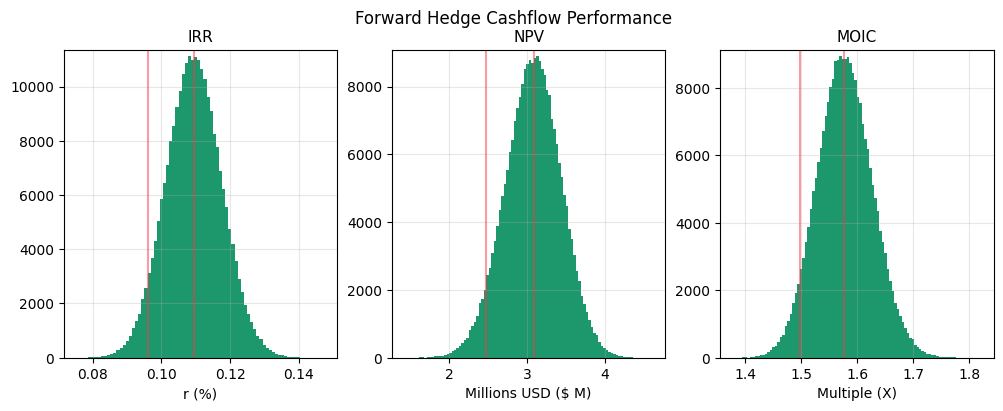

In [ ]:
# Forward Hedge Results
fig = plt.figure(figsize = (12, 4))
plt.suptitle('Forward Hedge Cashflow Performance')

# IRR - Internal Rate of Return
ax = plt.subplot2grid((1, 3), (0, 0))

y, x, _ = ax.hist(
    x=performance_forward['irr'],
    bins=80,
    color=colors['c3']
)

# IRR VaR 95%
ax.vlines(
    x=risk_irr_forward['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Median
ax.vlines(
    x=risk_irr_forward['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Layout
ax.set_title('IRR', fontsize=11)
ax.set_xlabel('r (%)')
ax.set_ylim([0, y.max() * 1.02])
ax.grid(True, alpha=0.3)

# NPV - Net PResent Value
ax = plt.subplot2grid((1, 3), (0, 1))

y, x, _ = ax.hist(
    x=performance_forward['npv'],
    bins=100,
    color=colors['c3']
)

# NPV VaR 95%
ax.vlines(
    x=risk_npv_forward['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# NPV Median
ax.vlines(
    x=risk_npv_forward['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5,
)

# NPV Layout
ax.set_title('NPV', fontsize=11)
ax.set_xlabel('Millions USD ($ M)')
ax.set_ylim([0, y.max() * 1.02])
#ax.set_ylim([0, 4200])
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}'))
#ax.set_xlim([-5*1e6, 0.0])
ax.grid(True, alpha=0.3)

# MOIC - Multiple on Invested Capital
ax = plt.subplot2grid((1, 3), (0, 2))

y, x, _ = ax.hist(
    x=performance_forward['moic'],
    bins=100,
    color=colors['c3'],
)

# MOIC VaR 95%
ax.vlines(
    x=risk_moic_forward['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Median
ax.vlines(
    x=risk_moic_forward['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Layout
ax.set_title('MOIC', fontsize=11)
ax.set_xlabel('Multiple (X)')
ax.set_ylim([0, y.max() * 1.02])
#ax.set_ylim([0, 5])
ax.grid(True, alpha=0.3)
plt.savefig(
    FIGURES_DIR / 'forward_hedge_cashflow_performance.png',
    dpi=300,
    bbox_inches='tight',
)


## 5. Option Hedge Strategy <a class='anchor' id='five'></a>
____

In [14]:
s0_series = get_latest_quote(
    market_data=market_data,
    analysis_start_date=global_variables.analysis_start_date,
    ticker='spot',
    price='mid',
)
s0 = float(s0_series.iloc[0])

# Ask price to buy Option
vol1y_series = get_latest_quote(
    market_data=market_data,
    analysis_start_date=global_variables.analysis_start_date,
    ticker='1y_atm_vol',
    price='ask',
)
vol5y_series = get_latest_quote(
    market_data=market_data,
    analysis_start_date=global_variables.analysis_start_date,
    ticker='5y_atm_vol',
    price='ask',
)

vol_1y = float(vol1y_series.iloc[0])
vol_5y = float(vol5y_series.iloc[0])

print('s0 (spot_mid):', s0)
print('vol_1y (ask):', vol1y_series)
print('vol_5y (ask):', vol5y_series)

# Convert vol from % to decimal
if vol_1y > 1.0:
    vol_1y /= 100.0
if vol_5y > 1.0:
    vol_5y /= 100.0

print('vol_1y (decimal):', vol_1y)
print('vol_5y (decimal):', vol_5y)


s0 (spot_mid): 1.15233
vol_1y (ask): 1y_atm_vol_ask    7.4
Name: 2025-08-01 00:00:00, dtype: float64
vol_5y (ask): 5y_atm_vol_ask    8.29
Name: 2025-08-01 00:00:00, dtype: float64
vol_1y (decimal): 0.07400000000000001
vol_5y (decimal): 0.08289999999999999


In [15]:
# Cashflows and their Dates 
cashflow_dates = np.asarray(cashflows.index)
cashflow_dates_idx = dates.get_indexer(cashflow_dates, method='pad')
cashflow_eur = np.asarray(cashflows['cf_eur'])

# Check Cashflow Dates Within Path Simulation Dates
if (cashflow_dates_idx < 0).any():
    missing = cashflow_dates[cashflow_dates_idx < 0]
    raise ValueError(f'Cashflow dates before simulation begins: {missing}')

In [ ]:
path_dates = pd.DatetimeIndex(dates)
cashflow_dates = pd.DatetimeIndex(cashflow_dates)
cashflow_eur = np.asarray(cashflow_eur, dtype=float)

hedge_cashflows_usd_option, premium_option, strikes, vols_used = put_option_hedge_cashflows_usd(
    spot_paths=spot_paths,
    path_dates=path_dates,
    cashflow_dates=cashflow_dates,
    cashflow_eur=cashflow_eur,
    s0=s0,
    r_domestic=global_variables.r_domestic,
    r_foreign= global_variables.r_foreign,
    vol_1y=vol_1y,
    vol_5y=vol_5y,
    hedge_ratio=global_variables.hedging_ratio,
    start_date=global_variables.analysis_start_date,
)

print('hedge_cashflows_usd_option shape:', hedge_cashflows_usd_option.shape)
print('premium_option (USD):', premium_option)
print('strikes:', strikes)
print('vols_used:', vols_used)

hedge_cashflows_usd_option shape: (250000, 5)
premium_option (USD): 1022357.3070999851
strikes: [       nan 1.18732081 1.21814517 1.28230542 1.3155957 ]
vols_used: [       nan 0.07437185 0.07659685 0.08105295 0.0829    ]


##### 5.1. Performance Evaluation <a class='anchor' id='five-one'></a>

In [17]:

cashflow_dates_idx = path_dates.get_indexer(cashflow_dates, method='pad')

# Expanded Cashflow Dates to Include premium payments upfront on analysis date
cashflow_dates_option = pd.DatetimeIndex(cashflow_dates).insert(0, global_variables.analysis_start_date)

# Prepering Perfromance Metrics
irr_option = np.empty(global_variables.n_paths, dtype=float)
moic_option = np.empty(global_variables.n_paths, dtype=float)
npv_option = np.empty(global_variables.n_paths, dtype=float)
terminal_option = np.empty(global_variables.n_paths, dtype=float)

for p in range(global_variables.n_paths):
    spots_on_cashflow_dates = spot_paths[p, cashflow_dates_idx]

    # Base + hedge USD cashflows at the loan cashflow dates (2025-10-01, ..., 2030-10-01)
    cashflow_usd_core = cashflow_eur * spots_on_cashflow_dates + hedge_cashflows_usd_option[p]

    cashflow_usd = np.concatenate([[-premium_option], cashflow_usd_core])

    irr_option[p] = irr(
        cashflow_dates=np.asarray(cashflow_dates_option),
        cashflows=cashflow_usd,
        start_date=cashflow_dates_option[0],
    )

    moic_option[p] = moic(cashflows=cashflow_usd)

    npv_option[p] = npv(
        cashflow_dates=np.asarray(cashflow_dates_option),
        cashflows=cashflow_usd,
        r=global_variables.discount_rate,
        start_date=global_variables.analysis_start_date,
    )

    terminal_option[p] = terminal_value(cashflows=cashflow_usd)

performance_option = {
    'strategy': 'option_put_atmf',
    'irr': irr_option,
    'moic': moic_option,
    'npv': npv_option,
    'terminal': terminal_option,
    'premium': premium_option,
    'strikes': strikes,
    'vols_used': vols_used,
}

nan_rate_irr_option = np.isnan(irr_option).mean()
print('IRR NaN rate :', nan_rate_irr_option)

IRR NaN rate : 0.0


##### 5.2. Risk Evaluation <a class='anchor' id='five-two'></a>

In [18]:
risk_npv_option = risk_summary_for_metric(performance_option['npv'], alpha=global_variables.alpha, loss='npv_shortfall')
risk_irr_option = risk_summary_for_metric(performance_option['irr'], alpha=global_variables.alpha, loss='irr_shortfall')
risk_moic_option = risk_summary_for_metric(performance_option['moic'], alpha=global_variables.alpha, loss='moic_shortfall')

p_npv_neg = prob_below(performance_option['npv'], 0.0)
p_irr_neg = prob_below(performance_option['irr'], 0.0)
p_moic_lt1 = prob_below(performance_option['moic'], 1.0)

##### 5.3. Results <a class='anchor' id='five-three'></a>

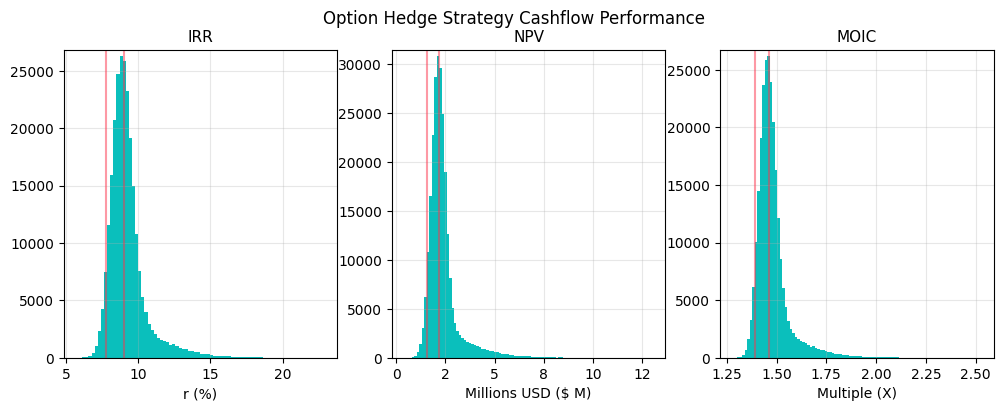

In [30]:
# Put Option Hedge Results
fig = plt.figure(figsize = (12, 4))
plt.suptitle('Option Hedge Strategy Cashflow Performance')

# IRR - Internal Rate of Return
ax = plt.subplot2grid((1, 3), (0, 0))

y, x, _ = ax.hist(
    x=performance_option['irr']*100,
    bins=80,
    color=colors['c4']
)

# IRR VaR 95%
ax.vlines(
    x=risk_irr_option['p05']*100,
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Median
ax.vlines(
    x=risk_irr_option['p50']*100,
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Layout
ax.set_title('IRR', fontsize=11)
ax.set_xlabel('r (%)')
ax.set_ylim([0, y.max() * 1.02])
ax.grid(True, alpha=0.3)

# NPV - Net PResent Value
ax = plt.subplot2grid((1, 3), (0, 1))

y, x, _ = ax.hist(
    x=performance_option['npv'],
    bins=100,
    color=colors['c4']
)

# NPV VaR 95%
ax.vlines(
    x=risk_npv_option['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# NPV Median
ax.vlines(
    x=risk_npv_option['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5,
)

# NPV Layout
ax.set_title('NPV', fontsize=11)
ax.set_xlabel('Millions USD ($ M)')
ax.set_ylim([0, y.max() * 1.02])
#ax.set_ylim([0, 4200])
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}'))
#ax.set_xlim([-5*1e6, 0.0])
ax.grid(True, alpha=0.3)

# MOIC - Multiple on Invested Capital
ax = plt.subplot2grid((1, 3), (0, 2))

y, x, _ = ax.hist(
    x=performance_option['moic'],
    bins=100,
    color=colors['c4'],
)

# MOIC VaR 95%
ax.vlines(
    x=risk_moic_option['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Median
ax.vlines(
    x=risk_moic_option['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Layout
ax.set_title('MOIC', fontsize=11)
ax.set_xlabel('Multiple (X)')
ax.set_ylim([0, y.max() * 1.02])
#ax.set_ylim([0, 5])
ax.grid(True, alpha=0.3)
plt.savefig(
    FIGURES_DIR / 'option_hedge_cashflow_performance.png',
    dpi=300,
    bbox_inches='tight',
)


## 6. Final Results <a class='anchor' id='six'></a>
___

In [ ]:
# TODO: move to global variables
strategies = {
    'Unhedged': performance_unhedged,
    'Forward Hedge': performance_forward,
    'Option Hedge': performance_option,
}

strategy_colors = {
    'Unhedged': colors['c1'],
    'Forward Hedge': colors['c3'],
    'Option Hedge': colors['c4'],
}

maturity_colors = [
    colors['c1'],
    colors['c2'],
    colors['c3'],
    colors['c4'],
]

alpha = global_variables.alpha

metrics = [
    ('irr',  'IRR',        lambda x: x*100,        'r (%)'),
    ('npv',  'NPV',        lambda x: x / 1e6,      'Millions USD ($ M)'),
    ('moic', 'MOIC',       lambda x: x,            'Multiple (X)'),
]



In [21]:
# TODO: reporting/visualisation module
def build_strategy_risk_table(results: dict, alpha: float = 0.95) -> pd.DataFrame:
    '''
    Table in metric space + downside-risk (shortfall) VaR/ES in loss space.
    '''
    npv_sum  = risk_summary_for_metric(results['npv'],  alpha=alpha, loss='npv_shortfall')
    irr_sum  = risk_summary_for_metric(results['irr'],  alpha=alpha, loss='irr_shortfall')
    moic_sum = risk_summary_for_metric(results['moic'], alpha=alpha, loss='moic_shortfall')

    df = pd.DataFrame(
        {
            'NPV (USD)': npv_sum,
            'IRR (dec)': irr_sum,
            'MOIC (x)': moic_sum,
        }
    ).T

    cols = [
        'n', 'mean', 'std', 'p05', 'p50', 'p95',
        f'VaR{int(alpha*100)}_loss',
        f'ES{int(alpha*100)}_loss',
    ]
    return df[[c for c in cols if c in df.columns]]


def print_strategy_report(name: str, results: dict, alpha: float = 0.95) -> None:
    print('\n' + '=' * 90)
    print(f'STRATEGY: {name}')
    print('=' * 90)

    if 'premium' in results:
        print(f'Premium (USD): {float(results['premium']):,.2f}')
    if 'forwards' in results:
        fw = np.asarray(results['forwards'], float)
        fw = fw[np.isfinite(fw)]
        if fw.size:
            print(f'Forwards: min={fw.min():.6f}  max={fw.max():.6f}')
    if 'strikes' in results:
        k = np.asarray(results['strikes'], float)
        k = k[np.isfinite(k)]
        if k.size:
            print(f'Strikes (ATMF): min={k.min():.6f}  max={k.max():.6f}')
    if 'vols_used' in results:
        v = np.asarray(results['vols_used'], float)
        v = v[np.isfinite(v)]
        if v.size:
            print(f'Vols used: min={v.min():.4f}  max={v.max():.4f}')

    df = build_strategy_risk_table(results, alpha=alpha)
    print(df.to_string(float_format=lambda x: f'{x:,.6g}'))

    print('\nProbabilities (bad outcomes):')
    print(f"  P(NPV < 0)   = {prob_below(results['npv'], 0.0):.4%}")
    print(f"  P(IRR < 0)   = {prob_below(results['irr'], 0.0):.4%}")
    print(f"  P(MOIC < 1)  = {prob_below(results['moic'], 1.0):.4%}")


##### 6.1. Unhedged Strategy <a class='anchor' id='six-one'></a>

In [22]:
print_strategy_report('UNHEDGED', performance_unhedged, alpha=alpha)


STRATEGY: UNHEDGED
Premium (USD): 0.00
                n        mean         std          p05         p50         p95  VaR95_loss   ES95_loss
NPV (USD) 250,000 1.48829e+06 1.96477e+06 -1.45616e+06 1.33334e+06 4.96557e+06 1.45616e+06 2.03624e+06
IRR (dec) 250,000   0.0777384   0.0374496    0.0170291   0.0771851    0.140465           0 0.000200221
MOIC (x)  250,000     1.40032    0.216529      1.07573     1.38324     1.78397           0  0.00082858

Probabilities (bad outcomes):
  P(NPV < 0)   = 23.1564%
  P(IRR < 0)   = 1.6520%
  P(MOIC < 1)  = 1.6520%


##### 6.2 Forward Strategy <a class='anchor' id='six-two'></a>

In [23]:
print_strategy_report('FORWARD HEDGE', performance_forward, alpha=alpha)


STRATEGY: FORWARD HEDGE
Premium (USD): 0.00
Forwards: min=1.157276  max=1.315596
                n        mean        std         p05         p50         p95  VaR95_loss  ES95_loss
NPV (USD) 250,000 3.07973e+06    359,402 2.47884e+06 3.08591e+06 3.65995e+06           0          0
IRR (dec) 250,000    0.109398 0.00811228   0.0961206    0.109368    0.122788           0          0
MOIC (x)  250,000     1.57749  0.0495969     1.49722     1.57679     1.66022           0          0

Probabilities (bad outcomes):
  P(NPV < 0)   = 0.0000%
  P(IRR < 0)   = 0.0000%
  P(MOIC < 1)  = 0.0000%


##### 6.3. Option Strategy <a class='anchor' id='six-three'></a>

In [24]:
print_strategy_report('OPTION HEDGE', performance_option, alpha=alpha)


STRATEGY: OPTION HEDGE
Premium (USD): 1,022,357.31
Strikes (ATMF): min=1.187321  max=1.315596
Vols used: min=0.0744  max=0.0829
                n        mean       std         p05         p50         p95  VaR95_loss  ES95_loss
NPV (USD) 250,000 2.36806e+06   807,757 1.56846e+06 2.20145e+06 3.97386e+06           0          0
IRR (dec) 250,000   0.0924945 0.0131318    0.077706   0.0900981    0.118398           0          0
MOIC (x)  250,000     1.47943 0.0834844     1.39176     1.46301     1.64152           0          0

Probabilities (bad outcomes):
  P(NPV < 0)   = 0.0000%
  P(IRR < 0)   = 0.0000%
  P(MOIC < 1)  = 0.0000%


##### 6.4. Visualisations <a class='anchor' id='six-four'></a>

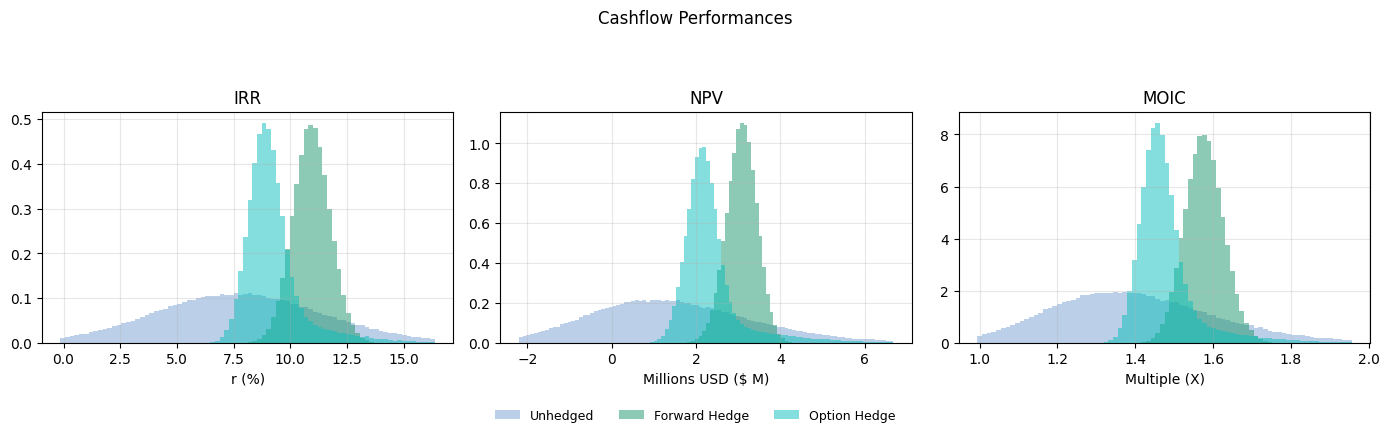

In [25]:
# Overlay of Histograms
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Cashflow Performances')

legend_handles = None
legend_labels = None

for ax, (key, title, transform, xlabel) in zip(axes, metrics):

    # build common bins on pooled data for comparison
    pooled = []
    for s in strategies.values():
        arr = np.asarray(s[key], float)
        arr = arr[np.isfinite(arr)]
        pooled.append(transform(arr))

    pooled = np.concatenate(pooled) if pooled else np.array([])
    if pooled.size == 0:
        ax.set_title(title)
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        continue

    bins = 80 if key != 'npv' else 100

    # clip extremes
    lo, hi = np.percentile(pooled, [0.5, 99.5])
    edges = np.linspace(lo, hi, bins + 1)

    for name, s in strategies.items():
        arr = np.asarray(s[key], float)
        arr = arr[np.isfinite(arr)]

        h = ax.hist(
            transform(arr),
            bins=edges,
            density=True,
            alpha=0.5,
            label=name,
            color=strategy_colors[name],
        )

    if legend_handles is None:
        legend_handles, legend_labels = ax.get_legend_handles_labels()

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.grid(True, alpha=0.3)

fig.legend(
    legend_handles,
    legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=3,
    frameon=False,
    fontsize=9,
)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.savefig(
    FIGURES_DIR / 'all_strategy_cashflow_performance.png',
    dpi=300,
    bbox_inches='tight',
)


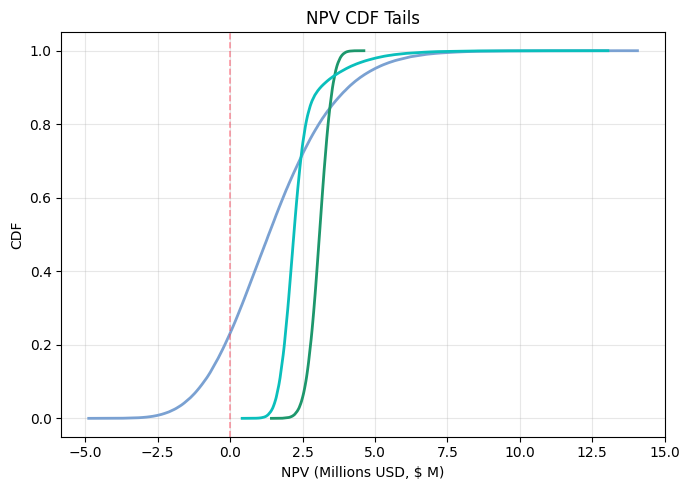

In [26]:
# Tail Comparison
fig = plt.figure(figsize=(7, 5))
plt.title('NPV CDF Tails')

for name, s in strategies.items():
    x = np.asarray(s['npv'], float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        continue

    x = np.sort(x)
    y = np.arange(1, x.size + 1) / x.size

    plt.plot(
        x / 1e6,
        y,
        color=strategy_colors[name],
        linewidth=2,
    )

# NPV Zero
plt.axvline(
    0.0,
    linestyle='--',
    linewidth=1.2,
    color=colors['c2'],
    alpha=0.5,
)

plt.xlabel('NPV (Millions USD, $ M)')
plt.ylabel('CDF')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(
    FIGURES_DIR / 'empirical_cdf_npv.png',
    dpi=300,
    bbox_inches='tight',
)

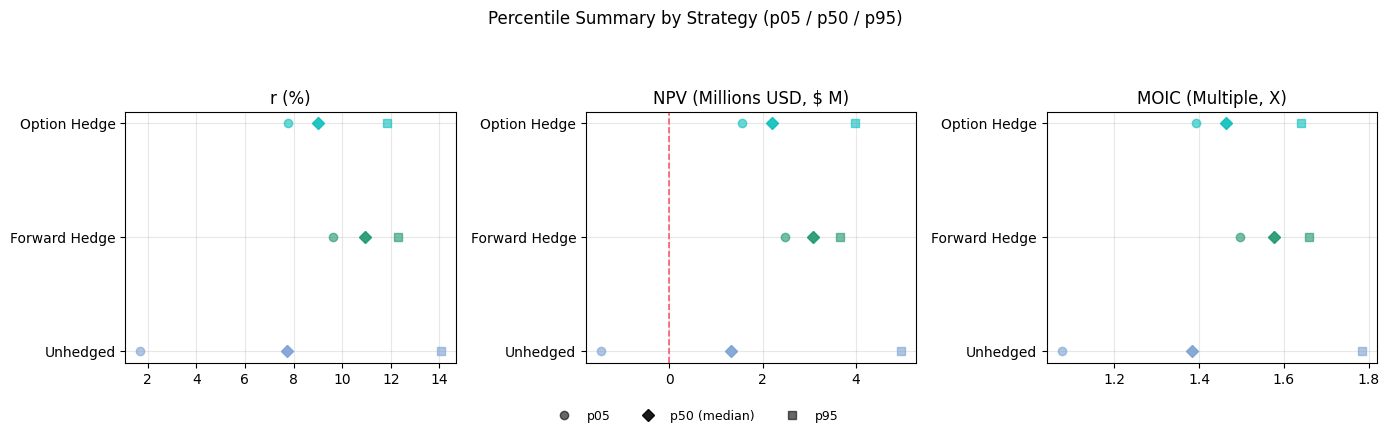

In [27]:
# Preparing Data
rows = []
for strat, s in strategies.items():
    for metric in ['irr', 'npv', 'moic']:
        x = np.asarray(s[metric], float)
        x = x[np.isfinite(x)]
        if x.size == 0:
            continue

        # scaling to percentage and millions
        if metric == 'irr':
            x = x * 100
        if metric == 'npv':
            x = x / 1e6

        p05, p50, p95 = np.percentile(x, [5, 50, 95])
        rows.append({'strategy': strat, 'metric': metric, 'p05': p05, 'p50': p50, 'p95': p95})

df_plot = pd.DataFrame(rows)

metric_names = {
    'irr': 'r (%)',
    'npv': 'NPV (Millions USD, $ M)',
    'moic': 'MOIC (Multiple, X)',
}

# Dot Plot for Percentiles
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Percentile Summary by Strategy (p05 / p50 / p95)')

plot_order = ['Unhedged', 'Forward Hedge', 'Option Hedge']

for ax, metric in zip(axes, ['irr', 'npv', 'moic']):
    sub = (
        df_plot[df_plot['metric'] == metric]
        .set_index('strategy')
        .loc[plot_order]
    )

    y = np.arange(len(sub.index))

    for i, strat in enumerate(sub.index):
        c = strategy_colors[strat]
        ax.plot(sub.loc[strat, 'p05'], i, marker='o', linestyle='None', color=c, alpha=0.6)
        ax.plot(sub.loc[strat, 'p50'], i, marker='D', linestyle='None', color=c, alpha=0.9)
        ax.plot(sub.loc[strat, 'p95'], i, marker='s', linestyle='None', color=c, alpha=0.6)

    ax.set_yticks(y)
    ax.set_yticklabels(sub.index)
    ax.set_title(metric_names[metric])
    ax.grid(True, alpha=0.3)

    # reference line
    if metric == 'npv':
        ax.axvline(
            x=0,
            linestyle='--',
            linewidth=1.2,
            color=colors['c2'],
            alpha=0.8
        )

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='black', alpha=0.6, label='p05'),
    plt.Line2D([0], [0], marker='D', linestyle='None', color='black', alpha=0.9, label='p50 (median)'),
    plt.Line2D([0], [0], marker='s', linestyle='None', color='black', alpha=0.6, label='p95'),
]

fig.legend(
    handles=handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=3,
    frameon=False,
    fontsize=9
)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.savefig(
    FIGURES_DIR / 'risk_summary_percentiles.png',
    dpi=300,
    bbox_inches='tight',
)

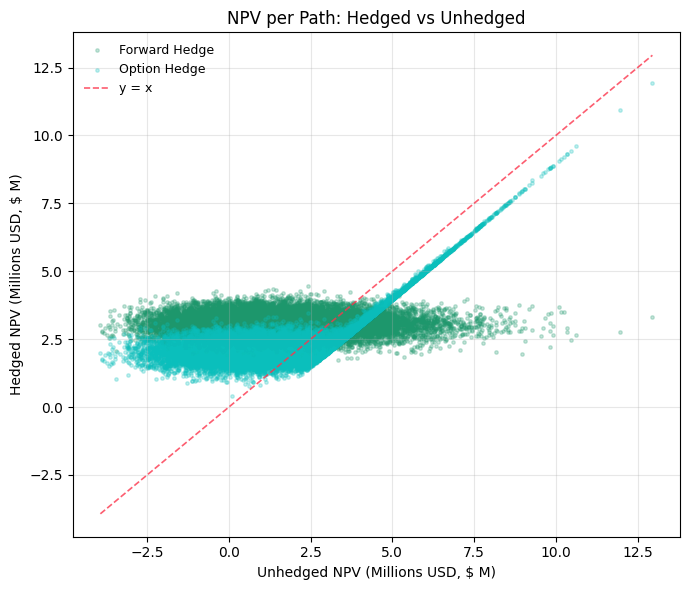

In [28]:
# Date Preperation
npv_u = np.asarray(performance_unhedged['npv'], float)
npv_f = np.asarray(performance_forward['npv'], float)
npv_o = np.asarray(performance_option['npv'], float)

mask = np.isfinite(npv_u) & np.isfinite(npv_f) & np.isfinite(npv_o)
npv_u, npv_f, npv_o = npv_u[mask], npv_f[mask], npv_o[mask]

# small subsample
n = min(20000, npv_u.size)
idx = np.random.default_rng(0).choice(npv_u.size, size=n, replace=False)

x = npv_u[idx] / 1e6
y_f = npv_f[idx] / 1e6
y_o = npv_o[idx] / 1e6

# Hedge Value Added: Hedged vs Unhedged scatter Plot
plt.figure(figsize=(7, 6))
plt.title('NPV per Path: Hedged vs Unhedged')

plt.scatter(
    x,
    y_f,
    s=6,
    alpha=0.25,
    color=colors['c3'],
    label='Forward Hedge',
)

plt.scatter(
    x,
    y_o,
    s=6,
    alpha=0.25,
    color=colors['c4'],
    label='Option Hedge',
)

lo = np.nanmin([x.min(), y_f.min(), y_o.min()])
hi = np.nanmax([x.max(), y_f.max(), y_o.max()])

plt.plot(
    [lo, hi],
    [lo, hi],
    linestyle='--',
    linewidth=1.2,
    color=colors['c2'],
    alpha=0.8,
    label='y = x',
)

plt.xlabel('Unhedged NPV (Millions USD, $ M)')
plt.ylabel('Hedged NPV (Millions USD, $ M)')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, frameon=False)
plt.tight_layout()
plt.savefig(
    FIGURES_DIR / 'npv_hedged_vs_unhedged.png',
    dpi=300,
    bbox_inches='tight',
)


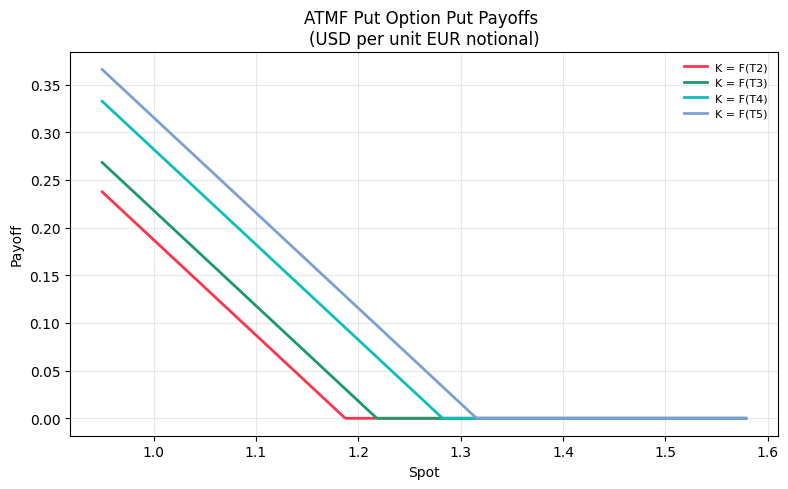

In [29]:
# Data prep: strikes
K = np.asarray(strikes, float)

s_min = 0.8 * np.nanmin(K)
s_max = 1.2 * np.nanmax(K)
S = np.linspace(s_min, s_max, 400)

# Option payoff by maturity
plt.figure(figsize=(8, 5))
plt.title('ATMF Put Option Put Payoffs \n(USD per unit EUR notional)')

for i, k in enumerate(np.asarray(strikes, float)):
    if not np.isfinite(k):
        continue

    payoff = np.maximum(k - S, 0)  # USD per 1 EUR

    plt.plot(
        S,
        payoff,
        color=maturity_colors[i % len(maturity_colors)],
        linewidth=2,
        label=f'K = F(T{i + 1})',
    )

plt.xlabel('Spot')
plt.ylabel('Payoff')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8, frameon=False)
plt.tight_layout()
plt.savefig(
    FIGURES_DIR / 'atmf_put_payoff_profiles.png',
    dpi=300,
    bbox_inches='tight',
)

## 1. Problem Statement and Quantitative Formulation
____
##### 1.1 Objective of the Exercise
The aim of this exercise isn't to construct a fully realistic private credit or FX trading system. It serves to demonstrate how to translate a loosely defined business requirement into quantitative concepts. This includes:

- formulating a concretely defined problem,
- suitability of model choices,
- ability to formulate a solution to the problem.

##### 1.2 Economic Framing
We'll be assuming the position of a private credit fund manager, with a USD-denominated fund, whose assets are EUR-denominated. And thus exposed to FX risk. All other risks such as Credit Risk, Interest Rate Risk aren't considered.

 - The investment generate EUR deterministic cashflows as follows:

| Cashflow Date | Cashflow (€ M) |
|---------------|----------------|
| 2025-10-01    | -10            |
| 2026-10-01    | 1              |
| 2027-10-01    | 1              |
| 2029-10-01    | 1              |
| 2030-10-01    | 11             |

 - The fund reports in USD
 - EURUSD FX is the only source of uncertainty affecting the USD value of the investment

### 1.3 Mathematical Framing and Problem Formulation
We define:

 - $\{CF_i^{EUR}\}_{i=1}^N$ as the set of deterministic EUR cashflows,
 - and $\{T_i\}_{i=1}^N$ their corresponding payment dates,
 - $S_t$ denote the EURUSD spot rate (USD per unit of EUR),
 - $t_0$ the analysis (valuation) date.

The unhedged USD cashflows are:

$$CF_i^{USD} = CF_i^{EUR} \cdot S_{T_i}$$

The FX spot rate is the only stochastic driver in the problem. And all other quantitites like cashflows, interest rates, option volatilites are treated deterministically at $t_0$.

The problem is to:
 - 1. Evaluate the performance of the USD investment and quantify the distribution introduced by FX uncertainty.
 - 2. Design hedging strategies using financial derivative products that mitigate the risk by modifying the distribution in controlled way.
 - 3. Identify the risk profiles associated with each hedging strategies and compare them in terms of:
    - downside risk reduction,
    - cost,
    - impact on upside potential.

## 2. Performance Metrics
___

### 2.1 Metric Selection
The investment profile portraid the traits of a bullet-loan where an upforont capital outlflow is followed by periodic interest payments and concluded with a final principal + interest.
These are commonly observed in private credit investments like direct lending or term loans. After some background reading, the following performance metrics were identified as appropriate trackers:

| Metric          | Question Answered                          |
|-----------------|--------------------------------------------|
| **NPV**         | Is the investment value-creating in USD terms? |
| **IRR**         | What is the annualised return profile?     |
| **MOIC**        | How much capital is returned per unit invested? |
| **Terminal Value** | What is the final USD outcome?             |

### 2.2 Metric Definitions

##### <u>__Net Present Value (NPV)__</u>

Sums the discounted USD cashflows to see if the exceed the required teturn rate, $r_m$, which is around $7\%$ in the Private Credit industry. PROVIDE REFERENCE.

$$NPV = \sum \frac{CF_i^{USD}}{(1 + r_m)^T_i}$$

- Positive NPV: Investment exceeds required return.
- Negative NPV: Investment underperforms the funds hurdle rate. 
- Sensitive to both IRR and timing of cashflows.

##### <u>__Internal Rate of Return (IRR)__</u>

The IRR finds what the $r_m$ is such that the NPV is equal to zero. IRR solves:

$$\sum \frac{CF_i^{USD}}{(1 + IRR)^T_i} = 0$$

- A high IRR (e.g. $>10\%$): Discount rate >> hurdle rate (NPV>0 at hurdle); strong outperformance.
- Zero IRR: Breakeven (NPV=0); not worth the investment.
- Negative IRR: Discount rate < 0 (NPV < 0 a $0\%$); capital destruction.
- Can become negative under adverse FX scenarios.
- Nonlinear. Small cashflow changes cause disporportional IRR swings. (ref. 2)
- Senstivity to early FX shocks.

##### <u>__Multiple of Invested Capital (MOIC)__</u>

Total USD cash inflows divided by absolute inital USD cash outflow. Not discounted.

$$MOIC = \frac{\sum CF_i^{USD}}{CF_0^{USD}}$$

- Intuitive capital efficieny metric.
- MOIC < 1 implies capital loss.
- FX depreciation directly reduces numerator.
- Unaffected by cashflow scheduel.

##### <u>__Terminal Value__</u>

 - Discloses end-state outcomes.
 - Usefule for tail analysis.

### 2.3 FX Impact

**EUR appreciates against USD, $S_{T_i}$ Increases**

 - USD value of future cash inflows increases.
 - NPV increases
 - IRR increases (larger effect when $S_{T_i}$ appreciation happens sooner)
 - MOIC increase proportionally to terminal USD cashflows


**EUR depreciates against USD, $S_{T_i}$ Decreases**

 - USD value of future cash inflows deacreases.
 - NPV may become negative.
 - IRR falls below zero if discounted cash inflows fail to recuperate initial cash outflow.

## 3. Modelling Framework
___

### 3.1 FX Spot Rate Model

##### <u>__Model Specification__</u>

The EURUSD Spot rate $S_{t}$, quoted as USD per EUR, is modelled as a Geometric Brownian Motion (GBM)_

$$dS_t = \sigma S_t dW_t$$

where:
 - $\sigma$ is the constant volatility,
 - $W_t$ a standard Brownian motion.

The exact solution to the SDE is:

$$S_t = S_0 \; \mathrm{exp} \left( - \frac{1}{2} \sigma^{2} t + \sigma W_{t} \right)$$

##### <u>__Choice of Drift__</u>

The drift term is set to:

$$ \mu = 0$$

The choice reflects a flat expected FX path scenario in our simulations.

**Rationale**

The scope and purpose of the exercise were considered. Introducing a non-zero drift would imbed macro views.
This would influence investment decisions from the onset which is conceptually seperate from the task at hand. The aim is to solve a hedging problem.
Setting $\mu$ to zero ensures that all risk stems purely from FX volatility. Like this, strategy differences arise from the hedging structures and investment performances are not inflated by macro trends.

**Why not Risk Neutral?**

Risk neutral dynamics are necessary for derivative pricing, but not for evaluating the real-world investments performances we are measuring. Under our framework:

 - FX Forwards and FX Options are priced analytically under no-arbitrage conditions using interest rate differentials.
 - Investment performance measures are evaluated under a real-world measure.
 - FX spot paths are simulated independenetly of pricing measure assumptions.

The seperation avoids assuming the investment as a risk-free asset. 

##### <u>__Volatility Estimation__</u>

Volatility is estimated from historical daily log returns of EURUSD:

 - Business-day sampling is used.
 - Weekend effects are implicitly embeded through friday to monday returns.
 - Each business day return representes a full calalander day exposure to FX risk.
 - Mid-rate log returns are used.

This ensured that the calibrated volatility is consistend with the simulation time grid. Time is measured in calander years using (ACT/365) day-count convention.

### 3.2 FX Forward Pricing Model

##### <u>__Pricing Relationship__</u>

FX forward rates are computed using covered interest parity (CIP):

$$ F \left(T\right) = S_{0} \; \mathrm{exp} \left( \left( r_{USD} - r_{EUR} \right) T \right) $$

where:

 - $S_0$ is the EURUSD spot rate observed at the valuation date,
 - $r_{\text{USD}}$ and $r_{\text{EUR}}$ are continuously compounded USD and EUR interest rates,
 - $T$ is the year fraction between the valuation date and the cashflow date (ACT/365).

This relationship is applied independently for each loan cashflow maturity.

##### <u>__Interest Rate Inputs and Proxies__</u>

USD and EUR interest rates are assumed deterministic and flat across maturities.
Proxy rates observed on the valuatation date, August 1st 2025, are used:

 - USD rate: $\mathrm{SOFR} = 4.34 \%$ (ref 5)
 - EUR rate: $\mathrm{€SRT} = 1.927 \%$ (ref 4)

These ares are sourced from Federal Reserve and ECB publications, respectively.

In a fully market-consistent implementation, forward rates would be computed using maturity-specific zero-coupon discount factors extracted from USD and EUR OIS curves. In the present analysis, flat rates are used:

 - isolate FX spot risk,
 - avoid curve-construction.

##### <u>__Interpretation__</u>

The forward rate embeds:

 - FX carry,
 - funding differentials betwen USD and EUR,
 - the oportunity cost of holding one currency over the other.

 Using CIP ensures:

  - no-arbitrage consistency,
  - determinsitic hedge cashflows once established.

Cross-currency basis effects are ignored and covered interest parity is assumed to hold.

### 3.3 FX Option Pricing Model

##### <u>__Model Choice__</u>

FX Options are priced using Garman-Kohlhagen model, which extends the Black Scholes model to foreign exchange markets.

The price of a European FX put option is given by:

$$ P_0 = e^{-r_{\text{USD}} T} \left( K \, \Phi(-d_2) - F(T)\, \Phi(-d_1) \right) $$

where:

$$
d_1 = \frac{\ln\!\left(\frac{F(T)}{K}\right) + \tfrac{1}{2}\sigma^2 T}{\sigma \sqrt{T}},
\qquad
d_2 = d_1 - \sigma \sqrt{T}.
$$

and:

 - $F\left(T\right)$ is the forward FX rate,
 - $K$ is the strike,
 - $\sigma$ is the implied volatility,
 - $\Phi\left(\cdot\right)$ is the standard normal CDF.

##### <u>__Volatility Input__</u>

ATM implied volatilities are used as model inputs:

 - 1-year and 5-year ATM implied vols are observed at the valuation date,
 - volatilities for intermediate maturities are obtained via linear interpolation,
 - smile and skew effects are ignored.

This choice reflects:

 - market observability,
 - alignment with the objective of downside protection rather than volatility trading.

##### <u>__Premium Treatment__</u>

Option premiums are computed at the valuation date and treated as upfront USD cash outflows.

In implementation:

 - a new cashflow date equal to the analysis date is introduced,
 - the premium is recorded as a negative USD cashflow at that date,
 - premiums are not discounted again, avoiding double counting.

This ensures correct cashflow timing and economic consistency.

## 4. Risk Metrics
___
Quantifying the FX risk is done via distributional risk measures computed across the Monte Carlo paths.
For each performance metric:

 - Mean, standard devaiton
 - Percentiles ($5\%$, $50\%$, $95\%$)
 - Tail probabilites:
    - $\mathrm{P}\left(\mathrm{NPV}<0\right)$
    - $\mathrm{P}\left(\mathrm{IRR}<0\right)$
    - $\mathrm{P}\left(\mathrm{MOIC}<1\right)$

Additionally:
 - Value-at-Risk (VaR)
 - Expected Shortfall (ES)

These metrics, implemented in the `metrics.risk.py` module, provide the link between the FX uncertainty and the investment outcomes. And allow for the direct comparison across strategies.

## 5. Hedging Strategies
___
Given the constraint and the nature of the exercise, focuse was only given to the canonical hedging strategies:
 - FX Forwards 
 - FX Options

In the first strategy we maximise certainty while in the second we mitigate downside risk while retaing upside potential.

The code was written in a modular manner that allows for other strategies to be explored in the future. 

##### 5.1 Forward Hedge Strategy

##### <u>__Design__</u>

The forward hedge is implemented as:
 - a cashflow-by-cashflow hedging,
 - 100% notional coverage of positive EUR cashflows,
 - a static hedge established at the valuation date.

For each EUR inflow at time $T_i$ a forward contract is entered with the notional equal to the expected EUR cashflow.

##### <u>__Pathwise Cashflow Construction__</u>

Unhedged USD cashflows are:

$$
CF_i^{\text{USD}} = CF_i^{\text{EUR}} \cdot S_{T_i}
$$

The forward hedge payoff is:

$$
\text{Hedge}_i
=
CF_i^{\text{EUR}} \cdot \left( F(T_i) - S_{T_i} \right)
$$

Resulting inthe fully hedged USD cashflows:

$$
\begin{aligned}
CF_i^{\text{USD, hedged}}
&= CF_i^{\text{EUR}} \cdot S_{T_i} + CF_i^{\text{EUR}} \cdot \left( F(T_i) - S_{T_i} \right) \\
&= CF_i^{\text{EUR}} \cdot F(T_i) \\
\end{aligned}
$$

FX uncertainty is therefore eliminated pathwise for hedged cashflows.

##### <u>__Risk Profile__</u>
 - FX volatility is almoset entirely removed.
 - Performance metric distributions become tightle concentrated.
 - Downside risk is minimised. 

##### <u>__Pros and Cons__</u>

**Pros**
- Simple and transpatent
- No upfront cost
- Predictable Outcomes

**Cons**
- No upside participation
- Locks in FX opportunity cost

## 5.2 Option Hedge Strategy

##### <u>__Design__</u>

The option hedge consists of purchasing:
- ATMF EUR Put (equivalent to USD Call)
- one option per EUR cashflow maturity.
- strikes set equaly to forward rate,
- premiums paid upfront at the valuation date.

##### <u>__Payoff Structure__</u>

The option payoff per cashflow is:

$$ \text{Payoff}_i = CF_i^{\text{EUR}} \cdot \max\!\left( K_i - S_{T_i},\, 0 \right) $$

where $K_i = F(T_i)$.

The USD cashdlow per path then becomes:

$$ CF_i^{\text{USD, hedged}} = CF_i^{\text{EUR}} \cdot S_{T_i} + \text{Payoff}_i$$

with the option premium recorded as an intial USD outflow.

$$
\begin{aligned}
CF_i^{\text{USD, hedged}}
&= CF_i^{\text{EUR}} \cdot S_{T_i} + CF_i^{\text{EUR}} \cdot \max\!\left( F(T_i) - S_{T_i},\, 0 \right) \\
&= CF_i^{\text{EUR}} \cdot \max\!\left( S_{T_i},\, F(T_i) \right).
\end{aligned}
$$

##### <u>__Risk Profile__</u>
 - Downside FX risk is capped.
 - Upside FX appreciation is presereved.
 - Distribution exhibit truncated left tails adn retained right tails.

##### <u>__Pros and Cons__</u>

**Pros**
- Downside protection
- Retained upside exposure

**Cons**
 - Premium cost
 - Lower Expected return than forwards

## 6. Parameter Choices and Risk Alignment
___

The two hedging strategies considered in this analysis are designed to align with distinc investor objectives and risk profiles. Rather than optimising a single criterion, the framework highlights the trad-offs between certainty, cost and convexity.

**Forward hedging** aligns with mandates prioritising capital certainty and cashflow predictability. By fixing the exchange rates in the future, you are eliminating any FX-driven variability in USD outcomes.This results in more concentrated distributions of IRR, NPV and MOIC with minimal downside risk. Such strategy is consistent with investors who value stability.

**Option-based hedging**, by contrast, alighs with downside controlled but upside seeking mandates. Buying ATMF EUR put options establishes a florr on the USD value of future cashflows without abdicating participation in favourable FX moves. This convex payoff structure truncates the left-tail outcomes at the cost of an upfront premium. The strategy is consistent with investors willing to pay for insurance against adverse FX scenarios but want to retain optionality, placing him or her somewhere between the unhedged investor and the forward hedging investor.

The appropriate strategy, therefore, depends on the investor preferences regarding:
 - Drawdown tolerance
 - Cost sensitivity (from Option premiums)
 - Demand for convexity

## 7. Assumptions, Simplifications, and Limitations
___

The analaysis relies on a number of explicit assumptions that were deliberate design choises.

##### <u>__Hedging Structure__</u>
 - **100% hedging of EUR inflows**

    Each positive EUR cashflow is hedged in full. Partial hedging or dynamic hedge ratios are not considered. Hedging ratio
    can be adjusted through the global varaible parameter `global_variables.GlobalVariables.hedging_ratio`.

- **Static cashflow-by-cashflow hedging**

    All hedges are established at the valuation date and held to maturity. There are no rebalancing, rolling or dynamic hedging perfomed.

- **Initial EUR cash outflow not hedged**

    The inital outflow of, what appears a loan principal, isn't hedged. The focus of analysis is on protecting future EUR inflows rather that funding FX risk at inception.

##### <u>__Costs and Market Frictions__</u>
- **Transaction costs**

    No transaction costs are modelled for the forwards. For options, the premium represents the sole explicit cost.

- **Bid-ask convention**

    Market-consistent pricing conventions were applied. Namely, FX spot path simulated mid price and was calibrated as such. Option premiums, on the other hand, were priced using ask implied volatilities, reflecting the cost of buying protection.

- **Bid-ask spread effect**

    No bid-ask spreads on forwards and options are modelled explicitly beyonf the use of ask volatilities for options. In practice, wider spreads would further increas transction costs impacting performance.

##### <u>__Interest Rates and FX Pricing__</u>

- **Deterministic interest rates**
    
    USD and EUR interest rates are assumed determinisitc and observed at the valuation date. They are solely used for FX forward and option pricing. 

- **Flat term structures**

    Flat proxy rates are used across diferent maturities (Section 3.2)

- **No cross-currency basis**

    Effects stemming from CCY basis were ignored. Theswe can have material impact in practice. Instead CIP is assumed (Section 3.2)

##### <u>__Option Specification__</u>

- **ATMF option strikes**

    Option strikes are set to the Forward rate at each maturity.

- **No volatility smile or skew modelling**

    Although market data for $25\Delta$ risk reversals and butterflies are provided, these are not used due to time constraints.

##### <u>__Stochastic Driver__</u>

- **FX spot as the sole stochastic driver**

    Credit risk, liquidity risk, interest rate risk, coutnerparty credit risk are not modelled

##### <u>__Interpretation__</u>

Put together, these assumptions imply a framework that should be interpreted as a clean and isolated FX risk exercise.
Far from a fully comprehensive investment model. The goal, reiterated here, is to:

- demonstrate how FX risk propagates through investment performance metrics
- compare hedging strategies under controlled conditions
- and provide a base that then can be extended to other strategies, model use and risk considerations.
